<a href="https://colab.research.google.com/github/costpetrides/NOx-Ozone-Relationship-Modeling-with-ML/blob/main/ML_O3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)


df = pd.read_csv("/content/NOxData.csv",
                 parse_dates=['Date'],  # change to date time format
                 index_col="Date")
df.head()


,MEANT,WINDIR,WINDSP,CLOUD,HUMID,PRECIP,PRES,VISIB,MAXT,MINT,SUNH,NO2,O3
Date,,,,,,,,,,,,,
2015-01-01,2,70,13,98,87,0.200,1025,10,4,1,3.800,9.175,0.008
2015-01-02,4,137,13,99,89,0.100,1019,8,5,4,3.800,9.308,0.006
2015-01-03,7,277,11,35,78,0.100,1016,9,14,3,7.100,10.917,0.022
2015-01-04,6,218,17,2,67,0.000,1030,10,8,2,8.700,4.764,0.029
2015-01-05,3,93,10,1,56,0.000,1036,10,8,-2,8.700,20.108,0.022


# K-Nearest Neighbors (KNN)

Best n_neighbors: 10
Best Validation Mean Squared Error: 3.6850579371423085e-05
Custom Regression Report:
Mean Absolute Error: 0.00492
Mean Squared Error: 0.00004
R-squared (R2): 0.65


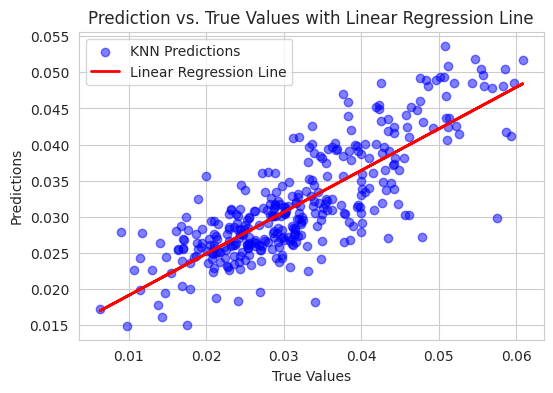

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Shuffle and split data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train, temp = train_test_split(df, test_size=0.4, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Preprocess data
def preprocess_data(dataframe):
    x = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return x, y

train_x, train_y = preprocess_data(train)
valid_x, valid_y = preprocess_data(valid)
test_x, test_y = preprocess_data(test)

# Standardize features
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)

# Define and tune model using GridSearchCV
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_x, train_y)

# Best parameters and model
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_knn_model = grid_search.best_estimator_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Validation Mean Squared Error: {-grid_search.best_score_}")

# Predict and evaluate on test set
pred_y = best_knn_model.predict(test_x)
mae = mean_absolute_error(test_y, pred_y)
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

print("Custom Regression Report:")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"Mean Squared Error: {mse:.5f}")
print(f"R-squared (R2): {r2:.2f}")

# Fit a linear regression model for plotting
lin_reg = LinearRegression()
lin_reg.fit(test_y.reshape(-1, 1), pred_y)
pred_line = lin_reg.predict(test_y.reshape(-1, 1))

# Plotting
plt.figure(figsize=(6, 4))
plt.scatter(test_y, pred_y, alpha=0.5, color='blue', label='KNN Predictions')
plt.plot(test_y, pred_line, color='red', linewidth=2, label='Linear Regression Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs. True Values with Linear Regression Line')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Regression

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Custom Regression Report (Tuned Model):
Mean Absolute Error: 0.00
Mean Squared Error: 0.00
R-squared (R2): 0.71


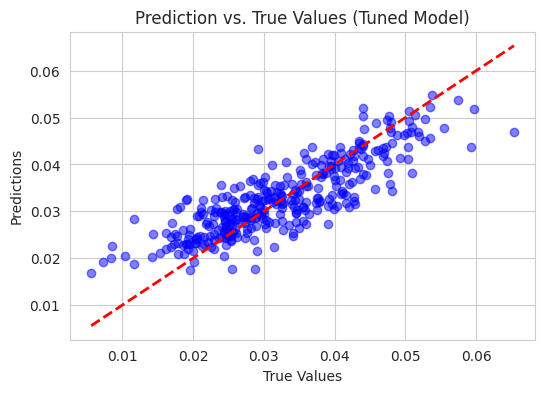

In [7]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV with 5-fold cross-validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model with the random search
rf_random.fit(train_x, train_y)

# Get the best parameters
print("Best Parameters:", rf_random.best_params_)

# Use the best parameters to predict on the test set
best_rf_model = rf_random.best_estimator_
pred_y_best = best_rf_model.predict(test_x)

# Evaluate the tuned model
mae_best = mean_absolute_error(test_y, pred_y_best)
mse_best = mean_squared_error(test_y, pred_y_best)
r2_best = r2_score(test_y, pred_y_best)

# Display results
print("Custom Regression Report (Tuned Model):")
print(f"Mean Absolute Error: {mae_best:.2f}")
print(f"Mean Squared Error: {mse_best:.2f}")
print(f"R-squared (R2): {r2_best:.2f}")

# Plot the results
plt.figure(figsize=(6, 4))
plt.scatter(test_y, pred_y_best, alpha=0.5, color='blue')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'r--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs. True Values (Tuned Model)')
plt.grid(True)
plt.show()


# Gradient Boosting Machines (GBM)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Custom Regression Report for GBM:
Mean Absolute Error: 0.00
Mean Squared Error: 0.00
R-squared (R2): 0.72


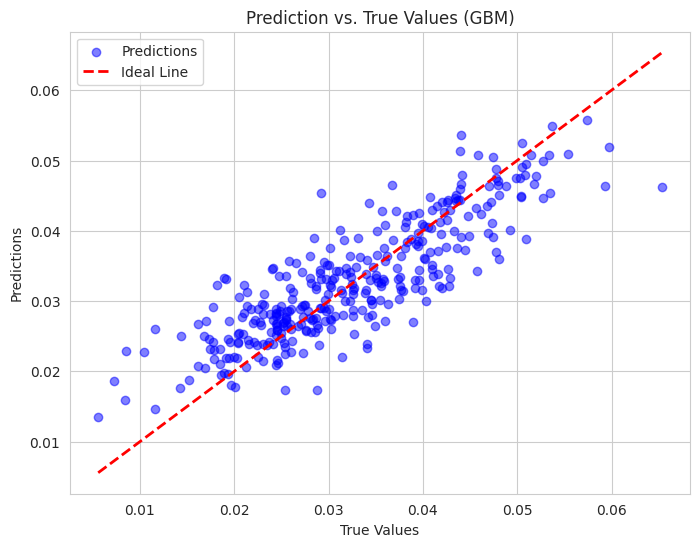

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define the Gradient Boosting Regressor model
gbm = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)

# Fit the GridSearchCV
grid_search.fit(train_x, train_y)

# Best GBM model
best_gbm = grid_search.best_estimator_

# Predict on the test set
pred_y_gbm = best_gbm.predict(test_x)

# Evaluate the model
mae_gbm = mean_absolute_error(test_y, pred_y_gbm)
mse_gbm = mean_squared_error(test_y, pred_y_gbm)
r2_gbm = r2_score(test_y, pred_y_gbm)

# Display the custom regression report for GBM
print("Custom Regression Report for GBM:")
print(f"Mean Absolute Error: {mae_gbm:.2f}")
print(f"Mean Squared Error: {mse_gbm:.2f}")
print(f"R-squared (R2): {r2_gbm:.2f}")

# Plot Prediction vs. True Values
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred_y_gbm, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'r--', linewidth=2, label='Ideal Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs. True Values (GBM)')
plt.legend()
plt.grid(True)
plt.show()


# XGBoost

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Custom Regression Report:
Mean Absolute Error: 0.00
Mean Squared Error: 0.00
R-squared (R2): 0.72


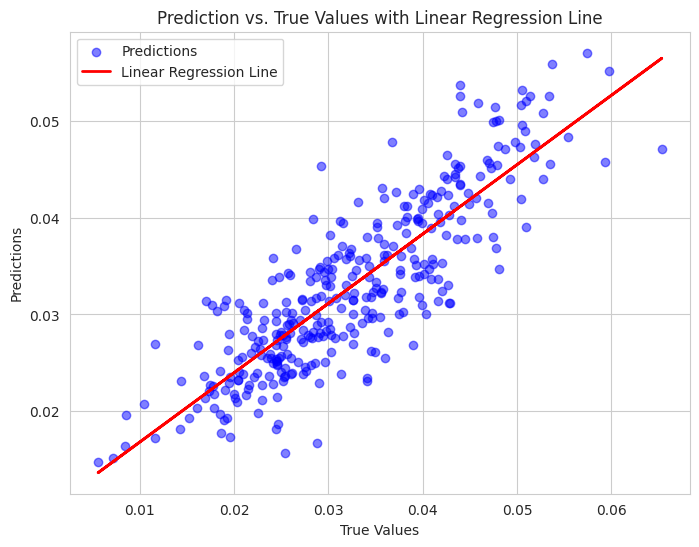

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training (60%) and test (40%) sets
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)

# Split the test set into validation (50%) and test (50%) sets
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Preprocessing function
def preprocess_data(dataframe, target_column):
    x = dataframe.drop(columns=[target_column]).values
    y = dataframe[target_column].values
    return x, y

# Apply preprocessing to datasets
train_x, train_y = preprocess_data(train_df, 'O3')
valid_x, valid_y = preprocess_data(valid_df, 'O3')
test_x, test_y = preprocess_data(test_df, 'O3')

# Standardize features (optional)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter tuning using Grid Search
param_grid = {
    'colsample_bytree': [0.3, 0.5],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [0, 10, 100],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(train_x, train_y)


# Best model from Grid Search
best_xg_reg = grid_search.best_estimator_

# Predict on the test set
pred_y = best_xg_reg.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, pred_y)
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

# Display the custom regression report
print("Custom Regression Report:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Fit a Linear Regression model to the data
linear_reg = LinearRegression()
linear_reg.fit(test_y.reshape(-1, 1), pred_y)

# Predict using the fitted linear regression model
regression_line = linear_reg.predict(test_y.reshape(-1, 1))

# Plot Prediction vs. True Values with Linear Regression Line
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred_y, alpha=0.5, color='blue', label='Predictions')
plt.plot(test_y, regression_line, color='red', linewidth=2, label='Linear Regression Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs. True Values with Linear Regression Line')
plt.legend()
plt.grid(True)
plt.show()